### This is a simple notebook to build, visualize, and diagnose the performance of DT algorithms on the (larger) habitable planets data set.

It accompanies Chapter 3 of the book.

Data for this exercise come from [here](http://phl.upr.edu/projects/habitable-exoplanets-catalog/data/database).

Author: Viviana Acquaviva

In [1]:
import pandas as pd

import numpy as np

import sklearn.tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics 
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
from sklearn.model_selection import KFold, StratifiedKFold

from scipy import stats

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [2]:
from io import StringIO  
from IPython.display import Image  
import pydotplus
from sklearn.tree import export_graphviz

In [3]:
import matplotlib
font = {'size'   : 20}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
matplotlib.rcParams['figure.dpi'] = 300

### Step 1: Preliminary data analysis/exploration.

Once we are working with research-level data sets, our first step should always be data exploration.

We can read the data in a data frame, as we did previously, and do some preliminary data analysis.

In [4]:
df = pd.read_csv('phl_exoplanet_catalog.csv', sep = ',')

In [5]:
df.head()

,P_NAME,P_STATUS,P_MASS,P_MASS_ERROR_MIN,P_MASS_ERROR_MAX,P_RADIUS,P_RADIUS_ERROR_MIN,P_RADIUS_ERROR_MAX,P_YEAR,P_UPDATED,...,P_HABZONE_CON,P_TYPE_TEMP,P_HABITABLE,P_ESI,S_CONSTELLATION,S_CONSTELLATION_ABR,S_CONSTELLATION_ENG,P_RADIUS_EST,P_MASS_EST,P_SEMI_MAJOR_AXIS_EST
0,11 Com b,3.0,6165.86330,-476.74200,476.74200,NaN,NaN,NaN,2007,2014-05-14,...,0,Hot,0,0.083813,Coma Berenices,Com,Berenice's Hair,12.082709,6165.86330,1.29
1,11 UMi b,3.0,4684.78480,-794.57001,794.57001,NaN,NaN,NaN,2009,2018-09-06,...,0,Hot,0,0.082414,Ursa Minor,UMi,Little Bear,12.229641,4684.78480,1.53
2,14 And b,3.0,1525.57440,NaN,NaN,NaN,NaN,NaN,2008,2014-05-14,...,0,Hot,0,0.081917,Andromeda,And,Andromeda,12.848516,1525.57440,0.83
3,14 Her b,3.0,1481.07850,-47.67420,47.67420,NaN,NaN,NaN,2002,2018-09-06,...,0,Cold,0,0.145241,Hercules,Her,Hercules,12.865261,1481.07850,2.93
4,16 Cyg B b,3.0,565.73385,-25.42624,25.42624,NaN,NaN,NaN,1996,2018-09-06,...,1,Warm,0,0.368627,Cygnus,Cyg,Swan,13.421749,565.73385,1.66


In [6]:
df.columns

Index(['P_NAME', 'P_STATUS', 'P_MASS', 'P_MASS_ERROR_MIN', 'P_MASS_ERROR_MAX',
       'P_RADIUS', 'P_RADIUS_ERROR_MIN', 'P_RADIUS_ERROR_MAX', 'P_YEAR',
       'P_UPDATED',
       ...
       'P_HABZONE_CON', 'P_TYPE_TEMP', 'P_HABITABLE', 'P_ESI',
       'S_CONSTELLATION', 'S_CONSTELLATION_ABR', 'S_CONSTELLATION_ENG',
       'P_RADIUS_EST', 'P_MASS_EST', 'P_SEMI_MAJOR_AXIS_EST'],
      dtype='object', length=112)

In [7]:
df.describe()

,P_STATUS,P_MASS,P_MASS_ERROR_MIN,P_MASS_ERROR_MAX,P_RADIUS,P_RADIUS_ERROR_MIN,P_RADIUS_ERROR_MAX,P_YEAR,P_PERIOD,P_PERIOD_ERROR_MIN,...,S_SNOW_LINE,S_ABIO_ZONE,S_TIDAL_LOCK,P_HABZONE_OPT,P_HABZONE_CON,P_HABITABLE,P_ESI,P_RADIUS_EST,P_MASS_EST,P_SEMI_MAJOR_AXIS_EST
count,4048.0,1598.000000,1467.000000,1467.000000,3139.000000,3105.000000,3105.000000,4048.000000,3.938000e+03,3.807000e+03,...,3786.000000,3.083000e+03,3281.000000,4048.000000,4048.000000,4048.000000,3721.000000,4048.000000,4048.000000,3978.000000
mean,3.0,798.384920,-152.292232,190.289692,4.191426,-0.483990,0.621867,2014.212945,2.309342e+03,-1.073631e+03,...,3.513348,1.768991e+35,0.440103,0.049654,0.034091,0.021986,0.261252,5.588647,323.089993,4.011385
std,0.0,1406.808654,783.366353,1082.061976,4.776830,1.409048,2.007592,3.704839,1.167012e+05,5.943181e+04,...,5.463171,6.944274e+36,0.074285,0.217256,0.181485,0.195731,0.131333,5.392733,965.084290,62.389968
min,3.0,0.019070,-24965.390000,0.000000,0.336300,-54.592700,0.000000,1989.000000,9.070629e-02,-3.650000e+06,...,0.002405,7.293660e-05,0.030707,0.000000,0.000000,0.000000,0.006768,0.000000,0.000000,0.004400
25%,3.0,26.548968,-79.457001,4.449592,1.569400,-0.526870,0.145730,2014.000000,4.497336e+00,-1.129000e-03,...,1.740762,5.264169e-01,0.420337,0.000000,0.000000,0.000000,0.196982,1.703920,3.628101,0.053000
50%,3.0,273.332080,-24.154928,25.108412,2.331680,-0.235410,0.325090,2016.000000,1.187053e+01,-9.392000e-05,...,2.568600,1.429118e+00,0.448357,0.000000,0.000000,0.000000,0.271192,2.667980,7.815324,0.102199
75%,3.0,806.488560,-4.392383,85.813561,3.553570,-0.134520,0.661390,2016.000000,4.186661e+01,-1.594000e-05,...,3.661581,2.641037e+00,0.472140,0.000000,0.000000,0.000000,0.303346,11.770500,149.379160,0.260507
max,3.0,17668.059000,0.270000,26630.808000,77.349000,0.450000,68.919080,2019.000000,7.300000e+06,3.200000e-02,...,104.112780,2.726899e+38,1.322542,1.000000,1.000000,2.000000,0.931208,77.349000,17668.059000,2500.000000


In [8]:
df.groupby('P_HABITABLE').count()

,P_NAME,P_STATUS,P_MASS,P_MASS_ERROR_MIN,P_MASS_ERROR_MAX,P_RADIUS,P_RADIUS_ERROR_MIN,P_RADIUS_ERROR_MAX,P_YEAR,P_UPDATED,...,P_HABZONE_OPT,P_HABZONE_CON,P_TYPE_TEMP,P_ESI,S_CONSTELLATION,S_CONSTELLATION_ABR,S_CONSTELLATION_ENG,P_RADIUS_EST,P_MASS_EST,P_SEMI_MAJOR_AXIS_EST
P_HABITABLE,,,,,,,,,,,,,,,,,,,,,
0,3993,3993,1575,1444,1444,3101,3067,3067,3993,3993,...,3993,3993,3666,3666,3993,3993,3993,3993,3993,3923
1,21,21,16,16,16,9,9,9,21,21,...,21,21,21,21,21,21,21,21,21,21
2,34,34,7,7,7,29,29,29,34,34,...,34,34,34,34,34,34,34,34,34,34


#### Start by lumping together Probably and Possibly Habitable planets.

In [9]:
bindf = df.drop('P_HABITABLE', axis = 1) #What are we doing here? Creating a new data frame called bindf and droppoing the old habitability tag

In [10]:
bindf['P_HABITABLE'] = (np.logical_or((df.P_HABITABLE == 1) , (df.P_HABITABLE == 2))) #how about here? creating my new habitability tag
bindf['P_HABITABLE'] = bindf['P_HABITABLE'].astype(int) #and here? Re-casting this column as integer

In [11]:
bindf.head()

,P_NAME,P_STATUS,P_MASS,P_MASS_ERROR_MIN,P_MASS_ERROR_MAX,P_RADIUS,P_RADIUS_ERROR_MIN,P_RADIUS_ERROR_MAX,P_YEAR,P_UPDATED,...,P_HABZONE_CON,P_TYPE_TEMP,P_ESI,S_CONSTELLATION,S_CONSTELLATION_ABR,S_CONSTELLATION_ENG,P_RADIUS_EST,P_MASS_EST,P_SEMI_MAJOR_AXIS_EST,P_HABITABLE
0,11 Com b,3.0,6165.86330,-476.74200,476.74200,NaN,NaN,NaN,2007,2014-05-14,...,0,Hot,0.083813,Coma Berenices,Com,Berenice's Hair,12.082709,6165.86330,1.29,0
1,11 UMi b,3.0,4684.78480,-794.57001,794.57001,NaN,NaN,NaN,2009,2018-09-06,...,0,Hot,0.082414,Ursa Minor,UMi,Little Bear,12.229641,4684.78480,1.53,0
2,14 And b,3.0,1525.57440,NaN,NaN,NaN,NaN,NaN,2008,2014-05-14,...,0,Hot,0.081917,Andromeda,And,Andromeda,12.848516,1525.57440,0.83,0
3,14 Her b,3.0,1481.07850,-47.67420,47.67420,NaN,NaN,NaN,2002,2018-09-06,...,0,Cold,0.145241,Hercules,Her,Hercules,12.865261,1481.07850,2.93,0
4,16 Cyg B b,3.0,565.73385,-25.42624,25.42624,NaN,NaN,NaN,1996,2018-09-06,...,1,Warm,0.368627,Cygnus,Cyg,Swan,13.421749,565.73385,1.66,0


### Let's select some columns.

S_MAG - star magnitude 

S_DISTANCE - star distance (parsecs)

S_METALLICITY - star metallicity (dex)

S_MASS - star mass (solar units)

S_RADIUS - star radius (solar units)

S_AGE - star age (Gy)

S_TEMPERATURE - star effective temperature (K)

S_LOG_G - star log(g)

P_DISTANCE - planet mean distance from the star (AU) 

P_FLUX - planet mean stellar flux (earth units)

P_PERIOD - planet period (days) 

### We can select the same features as we did in Chapter 2.

In [12]:
final_features = bindf[['S_MASS', 'P_PERIOD', 'P_DISTANCE']] 

In [13]:
targets = bindf.P_HABITABLE

In [14]:
final_features.head()

,S_MASS,P_PERIOD,P_DISTANCE
0,2.70,326.03000,1.324418
1,2.78,516.21997,1.534896
2,2.20,185.84000,0.830000
3,0.90,1773.40000,3.130558
4,1.08,798.50000,2.043792


### There are some NaNs. We can see this by using the "describe" property, which only counts numerical values in each column.

In [15]:
final_features.shape

(4048, 3)

In [16]:
final_features.describe()

,S_MASS,P_PERIOD,P_DISTANCE
count,3283.000000,3.938000e+03,3978.000000
mean,1.003838,2.309342e+03,4.047677
std,0.652903,1.167012e+05,62.435994
min,0.010000,9.070629e-02,0.004408
25%,0.810000,4.497336e+00,0.053110
50%,0.970000,1.187053e+01,0.103000
75%,1.130000,4.186661e+01,0.263415
max,23.560000,7.300000e+06,2500.000000


### We can count missing data by column...

In [17]:
for i in range(final_features.shape[1]):
    print(len(np.where(final_features.iloc[:,i].isna())[0]))

765
110
70


### ...and get rid of them (Note: there are much better imputing strategies!)

In [18]:
final_features = final_features.dropna(axis = 0) #gets rid of any instance with at least one NaN in any column
final_features.shape

(3180, 3)

### Next step: search for outliers

Method 1 - plot!

(array([4.400e+01, 1.260e+02, 2.940e+02, 1.085e+03, 1.027e+03, 3.720e+02,
        1.210e+02, 4.300e+01, 2.200e+01, 1.400e+01, 1.100e+01, 6.000e+00,
        2.000e+00, 3.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

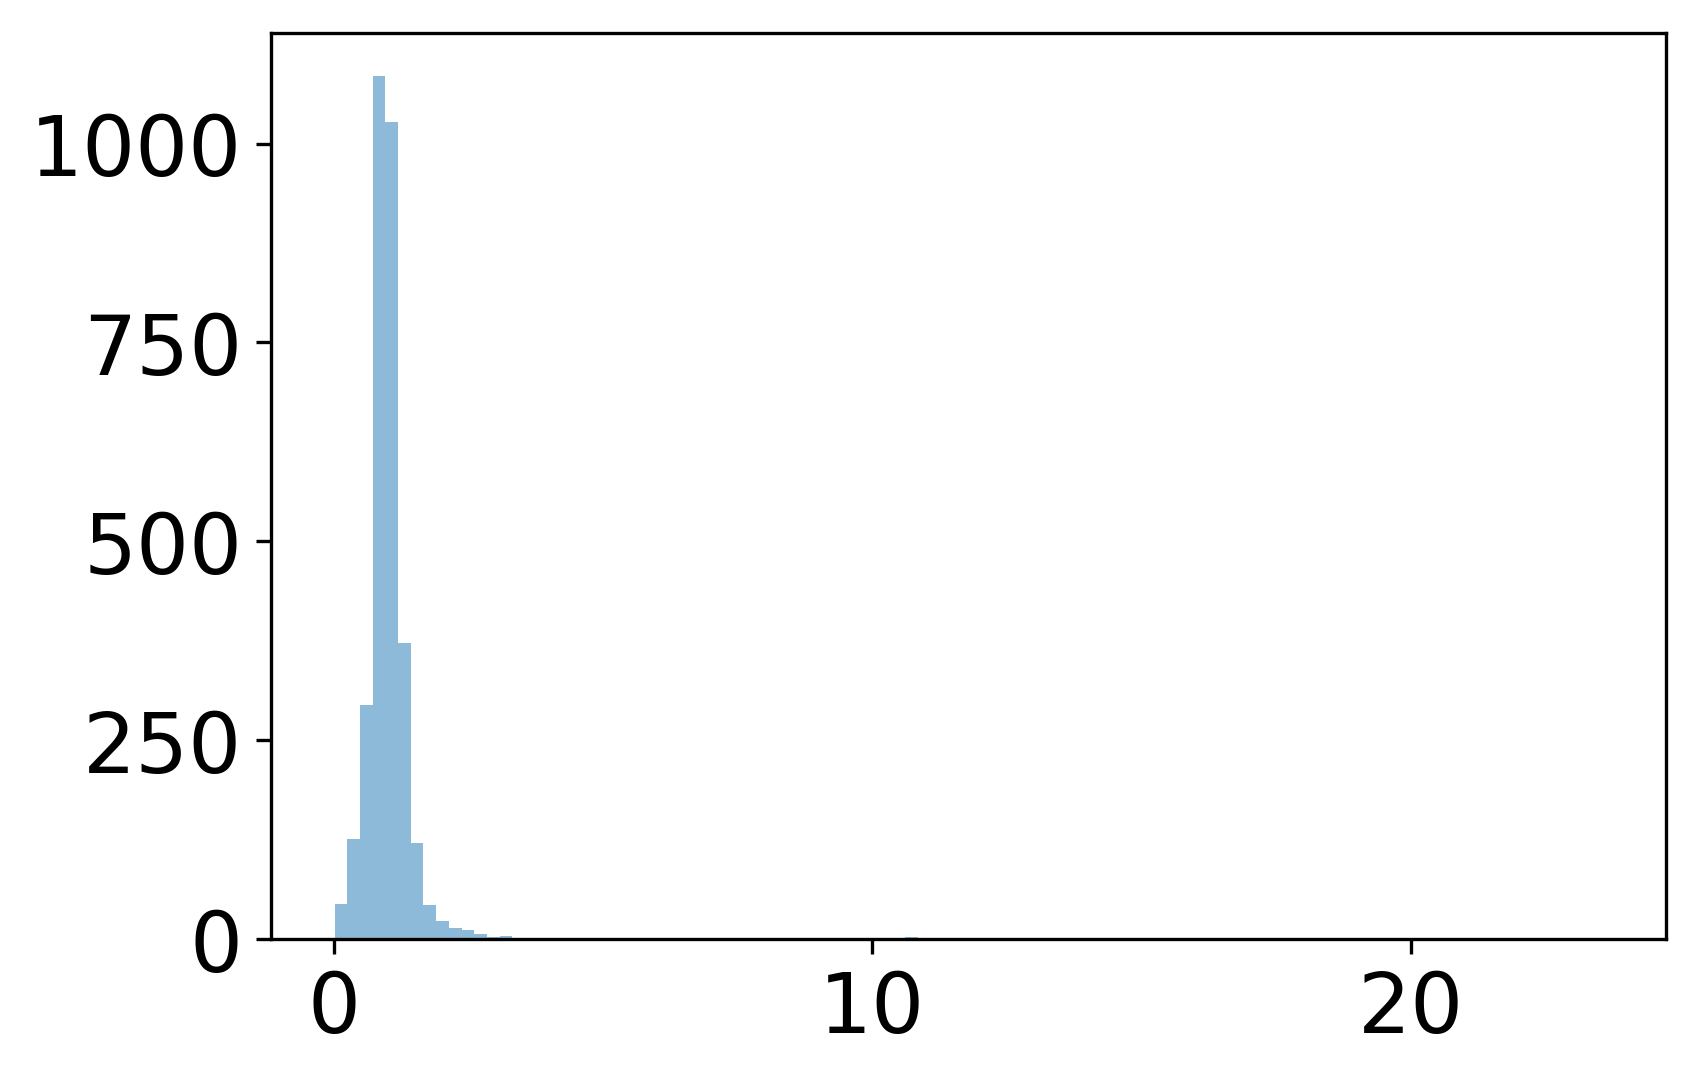

In [19]:
plt.hist(final_features.iloc[:,0], bins = 100, alpha = 0.5)

There is a remarkable outlier; the same happens for other features. 

But we could have also known from the difference between mean and median (which, in fact, is even more pronounced for orbital distance and period).

In [20]:
final_features.describe()

,S_MASS,P_PERIOD,P_DISTANCE
count,3180.000000,3.180000e+03,3180.000000
mean,1.018217,2.763531e+03,0.677663
std,0.649450,1.298246e+05,5.962161
min,0.020000,9.070629e-02,0.004408
25%,0.820000,4.175797e+00,0.050453
50%,0.970000,1.155546e+01,0.097369
75%,1.130000,5.474041e+01,0.274581
max,23.560000,7.300000e+06,243.000000


In [21]:
final_features = final_features[(np.abs(stats.zscore(final_features)) < 5).all(axis=1)] 

#This eliminates > 5 sigma outliers; however it counts from the mean so it might not be ideal

In [22]:
targets = targets[final_features.index]

### Now reset index.

In [23]:
final_features = final_features.reset_index(drop=True)

In [24]:
final_features.head()

,S_MASS,P_PERIOD,P_DISTANCE
0,2.70,326.03000,1.324418
1,2.78,516.21997,1.534896
2,2.20,185.84000,0.830000
3,0.90,1773.40000,3.130558
4,1.08,798.50000,2.043792


### And don't forget to do the same for the label vector.

In [25]:
targets = targets.reset_index(drop=True)

In [26]:
targets.head()

0    0
1    0
2    0
3    0
4    0
Name: P_HABITABLE, dtype: int64

### Comparing the shapes, we can see that 9 outliers were eliminated.

In [27]:
targets.shape

(3171,)

### Check balance of data set

In [ ]:
#Simple way: count 0/1s, get fraction of total

In [28]:
np.sum(targets)/len(targets)

0.01639861242510249

In [29]:
np.bincount(targets) #this shows the distribution of the two classes

array([3119,   52])

### This tells us that our data set is extremely imbalanced, and therefore, we need to be careful.

#### Finally, we can explore the data by class, to get a sense of how the two classes differ from one another. For this, we need to concatenate the feature/labels data frames so we group by objects label.

In [30]:
#Note: this generates a "view", not a new data frame

pd.concat([final_features, targets], axis=1)

,S_MASS,P_PERIOD,P_DISTANCE,P_HABITABLE
0,2.70,326.030000,1.324418,0
1,2.78,516.219970,1.534896,0
2,2.20,185.840000,0.830000,0
3,0.90,1773.400000,3.130558,0
4,1.08,798.500000,2.043792,0
5,2.30,993.300000,2.608320,0
6,0.99,30.350600,0.190168,0
7,1.54,452.800000,1.338399,0
8,1.54,883.000000,2.167464,0
9,0.48,416.000000,0.920000,0


In [31]:
#We can group by label and take a look at summary statistics

pd.concat([final_features, targets], axis=1).groupby('P_HABITABLE').describe(percentiles = [])

S_MASS                                        P_PERIOD  \
              count      mean       std   min    50%   max    count   
P_HABITABLE                                                           
0            3119.0  1.003520  0.341290  0.02  0.980  4.26   3119.0   
1              52.0  0.486538  0.285079  0.08  0.475  1.12     52.0   

                                                                        \
                   mean          std       min        50%          max   
P_HABITABLE                                                              
0            296.532141  1340.624871  0.090706  11.230000  43500.00000   
1             91.035689   100.689713  4.049610  47.481208    448.30356   

            P_DISTANCE                                                     
                 count      mean       std       min       50%        max  
P_HABITABLE                                                                
0               3119.0  0.534470  1.370882  0.004408  0.095352  25.426153  
1                 52.0  0.302263  0.276637  0.021493  0.205800   1.190229

#### We can also just take a look at the first two features, using different symbols for the two classes.

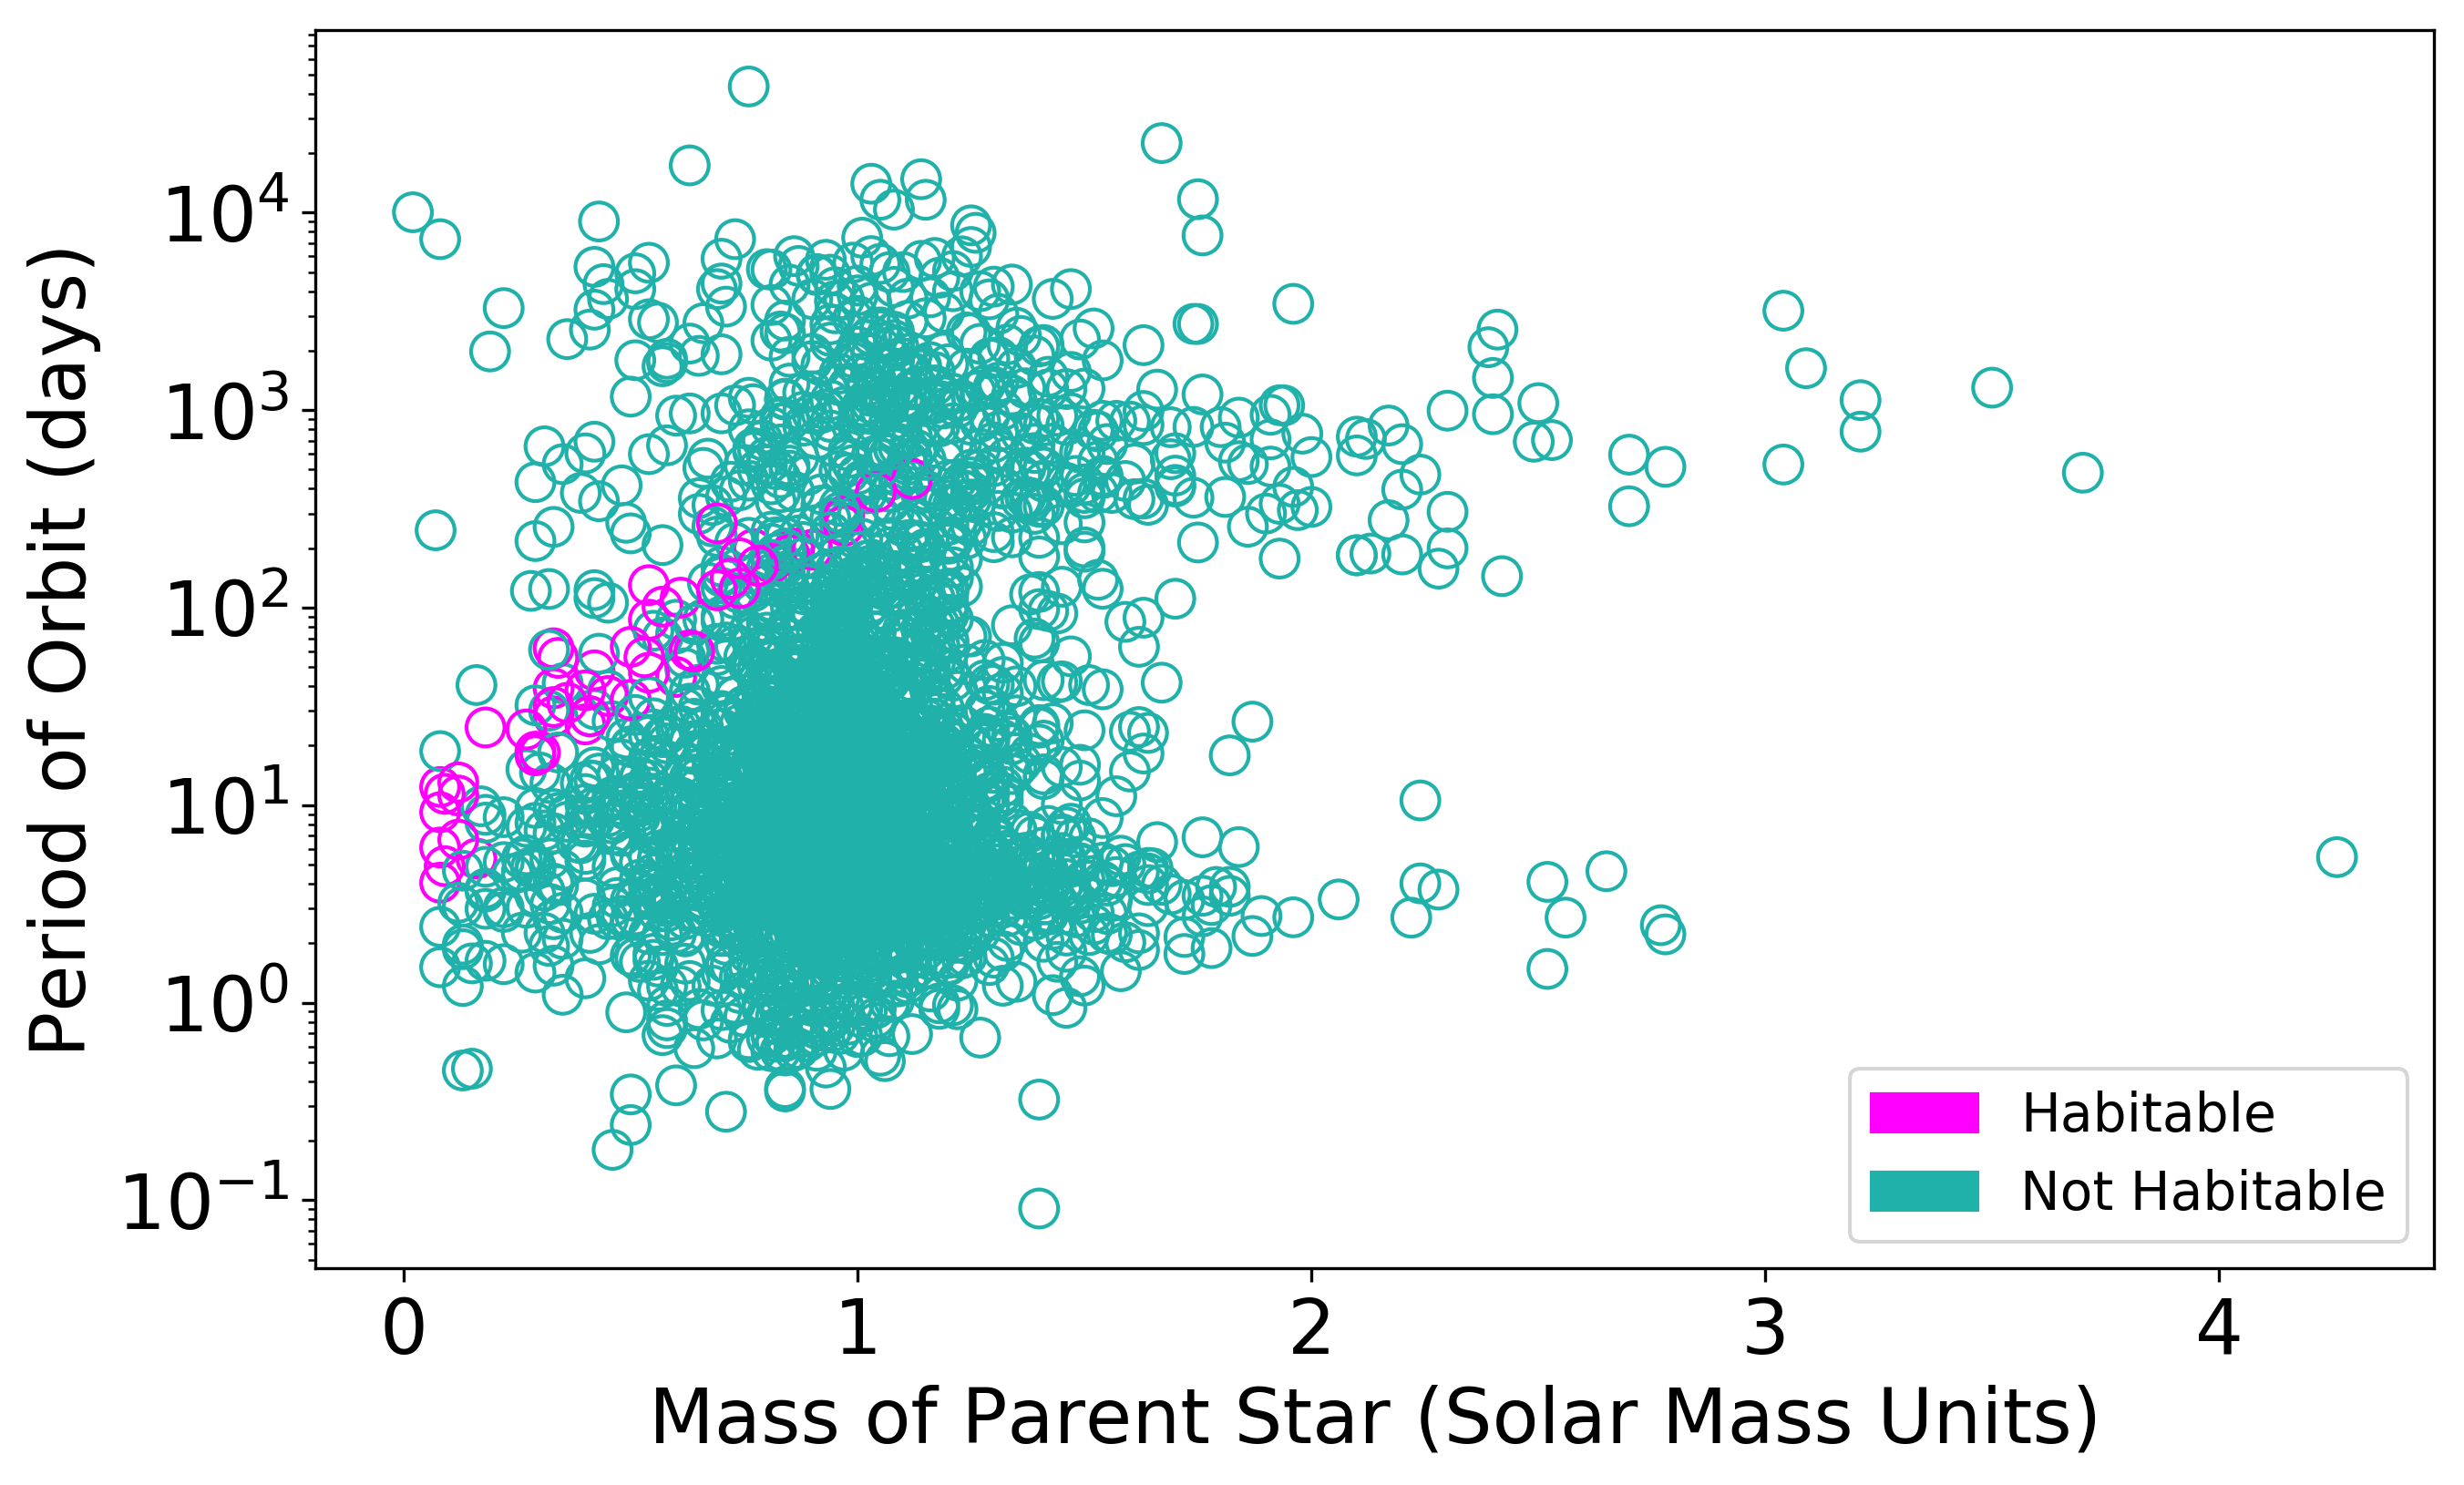

In [32]:
plt.figure(figsize=(10,6))

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ['#20B2AA','#FF00FF'])

a = plt.scatter(final_features['S_MASS'], final_features['P_PERIOD'], marker = 'o',\
            c = targets, s = 100, cmap=cmap, label = 'Test')

plt.legend();

a.set_facecolor('none')

plt.yscale('log')
plt.xlabel('Mass of Parent Star (Solar Mass Units)')
plt.ylabel('Period of Orbit (days)');

bluepatch = mpatches.Patch(color='#20B2AA', label='Not Habitable')
magentapatch = mpatches.Patch(color='#FF00FF', label='Habitable')

ax = plt.gca()
leg = ax.get_legend()

plt.legend(handles=[magentapatch, bluepatch],\
           loc = 'lower right', fontsize = 14);

### Questions: 

- Based on this graph, would you expect DT or kNN to perform better? Why?
    
- What kind of performance can we expect (qualitatively, is the information sufficient?) Do you expect to have latent (hidden) variables that might affect the outcome beyond those that we have?



### Ok, this is all for preliminary data exploration. Time to deploy.

We begin with a random train/test split, and will do cross validation later.

In [33]:
Xtrain, Xtest, ytrain, ytest = train_test_split(final_features, targets, random_state=2)

In [34]:
Xtrain.shape, Xtest.shape

((2378, 3), (793, 3))

Let's pick the DT method (fixing random state) and build the model.

In [35]:
model = DecisionTreeClassifier(random_state=5)

model.fit(Xtrain, ytrain)

DecisionTreeClassifier(random_state=5)

#### Let's visualize the graph!

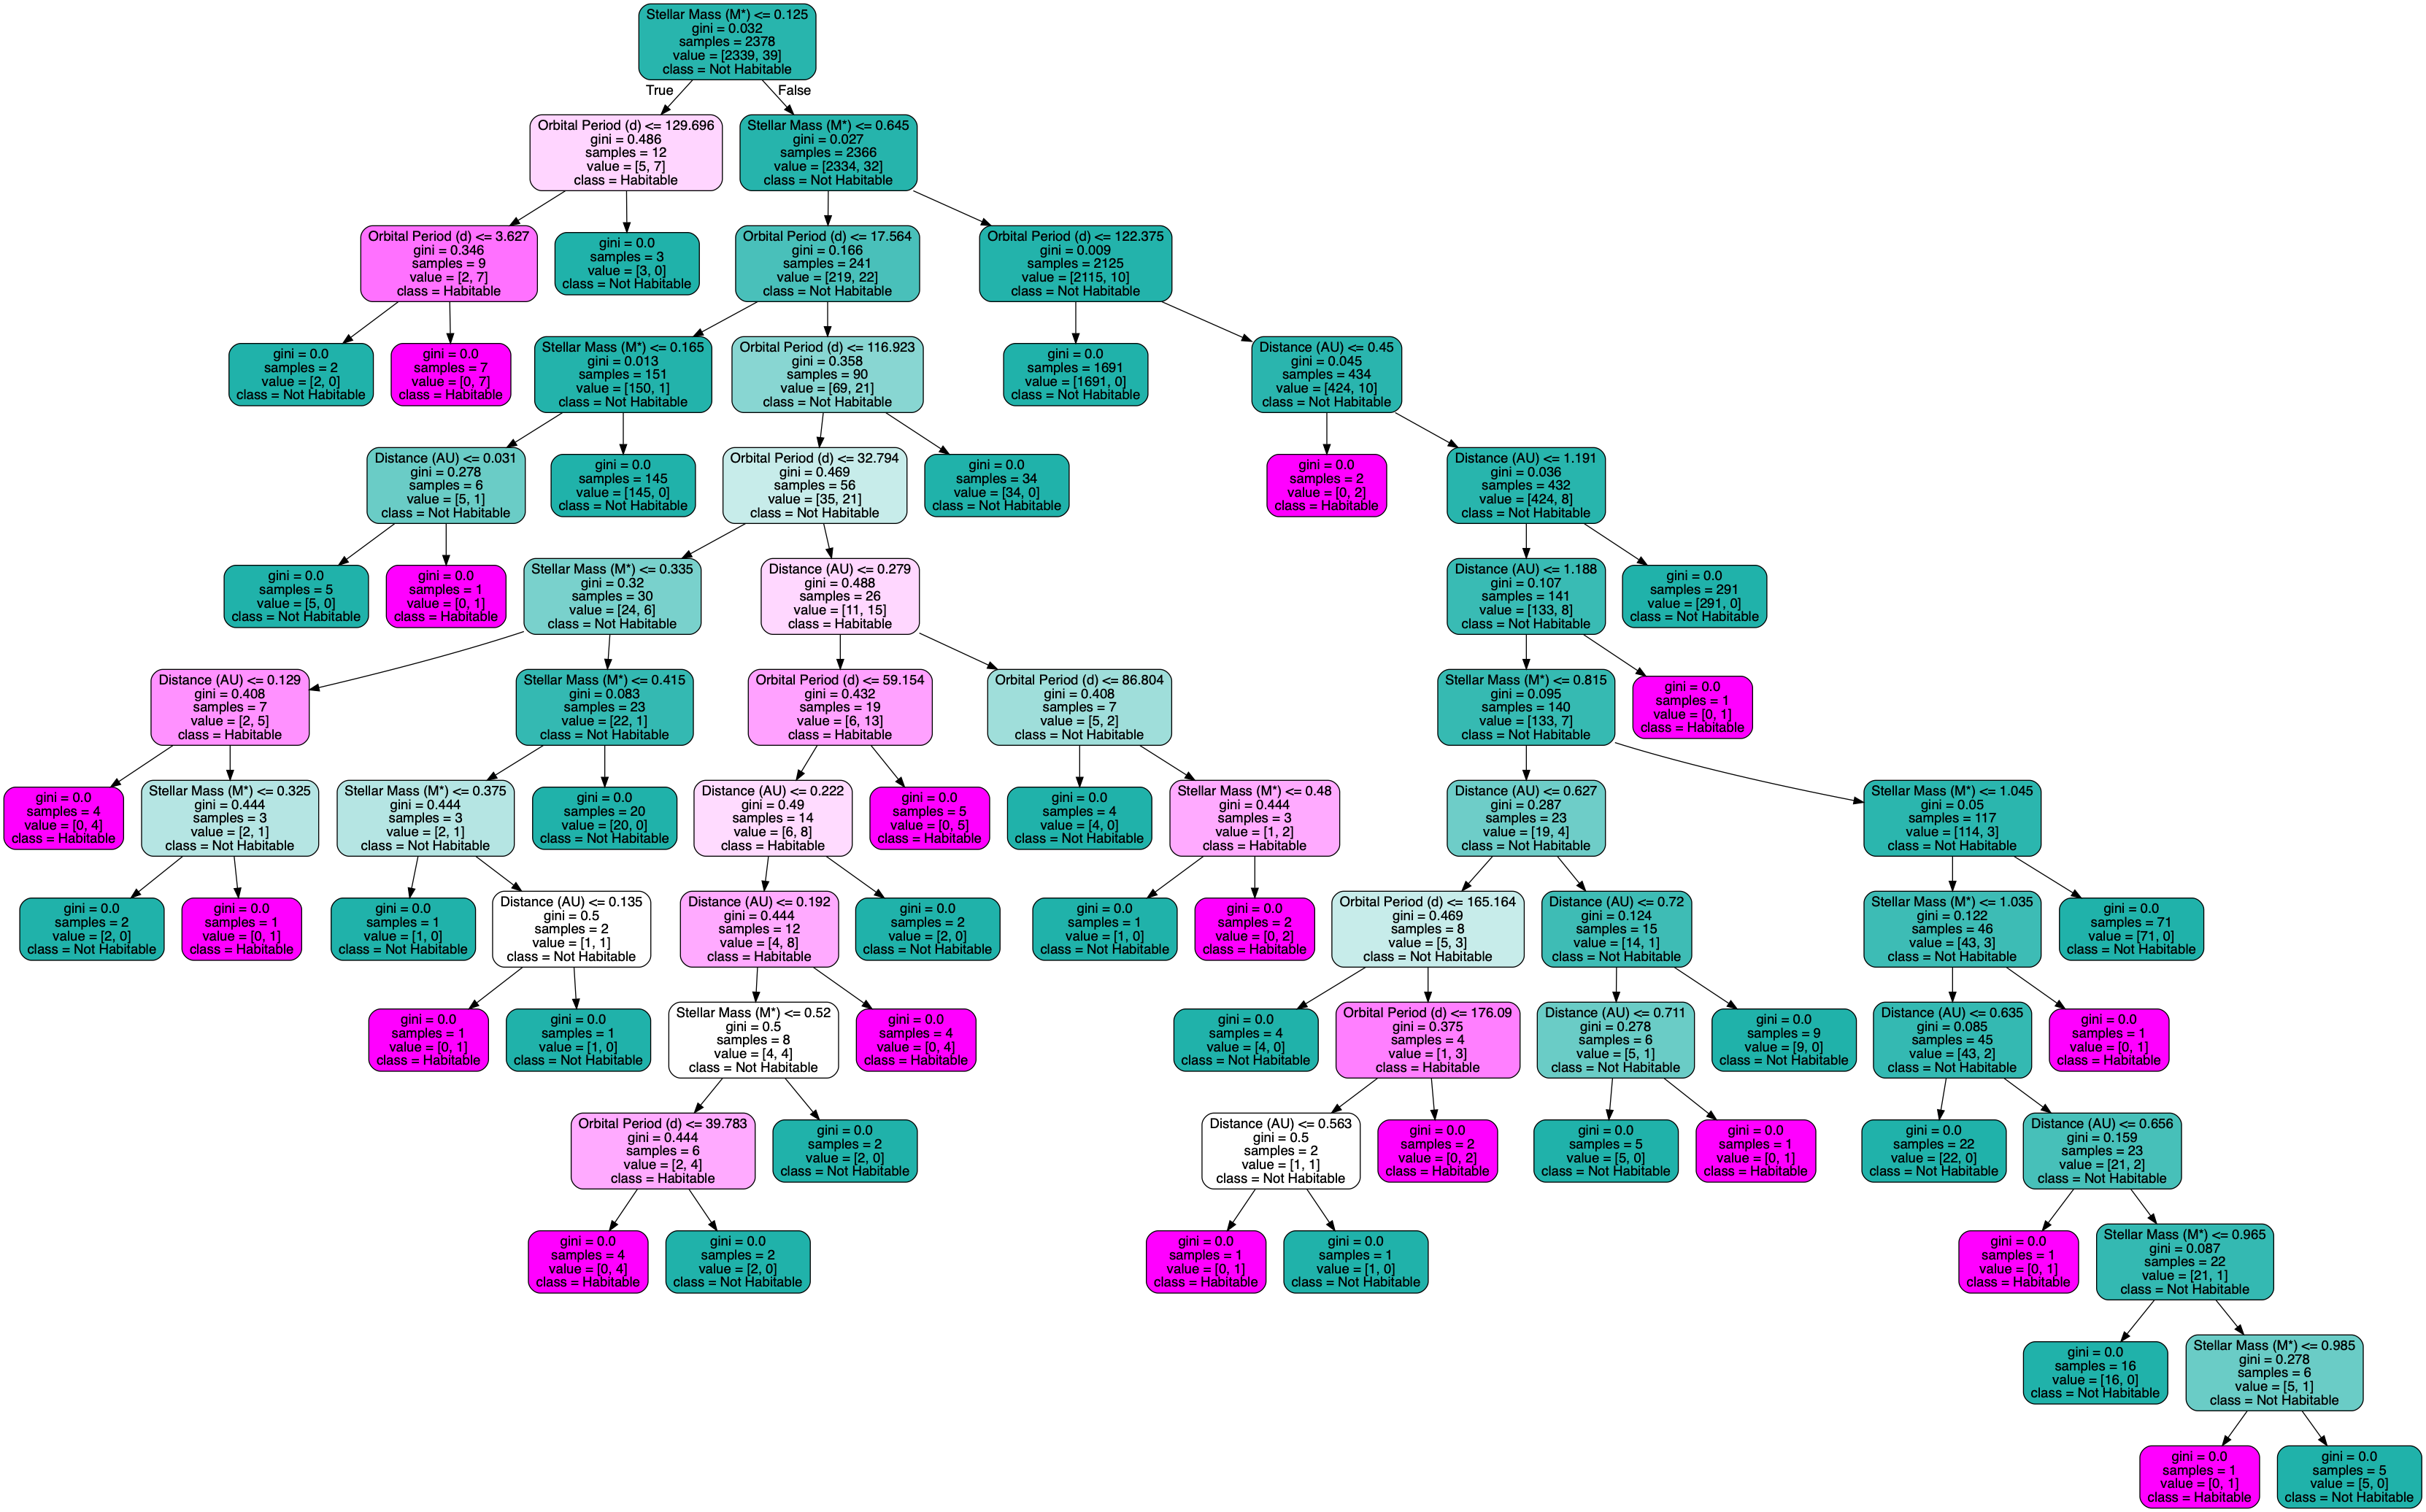

In [36]:
# Reminder: The features are always randomly permuted at each split. 
# Therefore, the best found split may vary, even with the same training data 
# and max_features=n_features, if the improvement of the criterion is identical 
# for several splits enumerated during the search of the best split. 
# To obtain a deterministic behaviour during fitting, random_state has to be fixed.

dot_data = StringIO()
export_graphviz(
            model,
            out_file =  dot_data,
            feature_names = ['Stellar Mass (M*)', 'Orbital Period (d)', 'Distance (AU)'],
            class_names = ['Not Habitable','Habitable'],
            filled = True,
rounded = True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
nodes = graph.get_node_list()

for node in nodes:
    if node.get_label():
        values = [int(ii) for ii in node.get_label().split('value = [')[1].split(']')[0].split(',')]
        values = [255 * v / sum(values) for v in values]
        
        values = [int(255 * v / sum(values)) for v in values]
            
        if values[0] > values[1]:
            alpha = int(values[0] - values[1])
            alpha = '{:02x}'.format(alpha) #turn into hexadecimal
            color = '#20 B2 AA'+str(alpha)
        else:
            alpha = int(values[1] - values[0])
            alpha = '{:02x}'.format(alpha)
            color = '#FF 00 FF'+str(alpha)
        node.set_fillcolor(color)

#graph.write_png('Graph.png',dpi = 300)
        
Image(graph.create_png())

### Question: Can you predict the accuracy score on the train set?

100%, like all the "unleashed" decision trees.

### Let's take a look at train/test scores.

In [37]:
print(metrics.accuracy_score(ytrain, model.predict(Xtrain))) #train score

print(metrics.accuracy_score(ytest, model.predict(Xtest))) #test score

1.0
0.9848675914249685


This looks pretty high, but how does it compare with the accuracy of a lazy classifier that places everything in the "not habitable" category?

In [38]:
#Dummy classifier

print(metrics.accuracy_score(ytest, np.zeros(len(ytest)))) #performance of a dummy classifier


0.9836065573770492


### We can look at other metrics.

In [39]:
print(metrics.precision_score(ytest,model.predict(Xtest)))

0.5384615384615384


In [40]:
print(metrics.recall_score(ytest,model.predict(Xtest)))

0.5384615384615384


How are they overall?

Not great.




### You know what we would need in order to understand exactly how the model is working? A confusion matrix!

In [41]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.figure(figsize=(7,6))
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center", verticalalignment="center",
                 color="green" if i == j else "red", fontsize = 30)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### We can plot the confusion matrix.

Note that so far, we use the predictions on *one* test fold, so the numbers will refer to the test set only.

Confusion matrix, without normalization
[[774   6]
 [  6   7]]


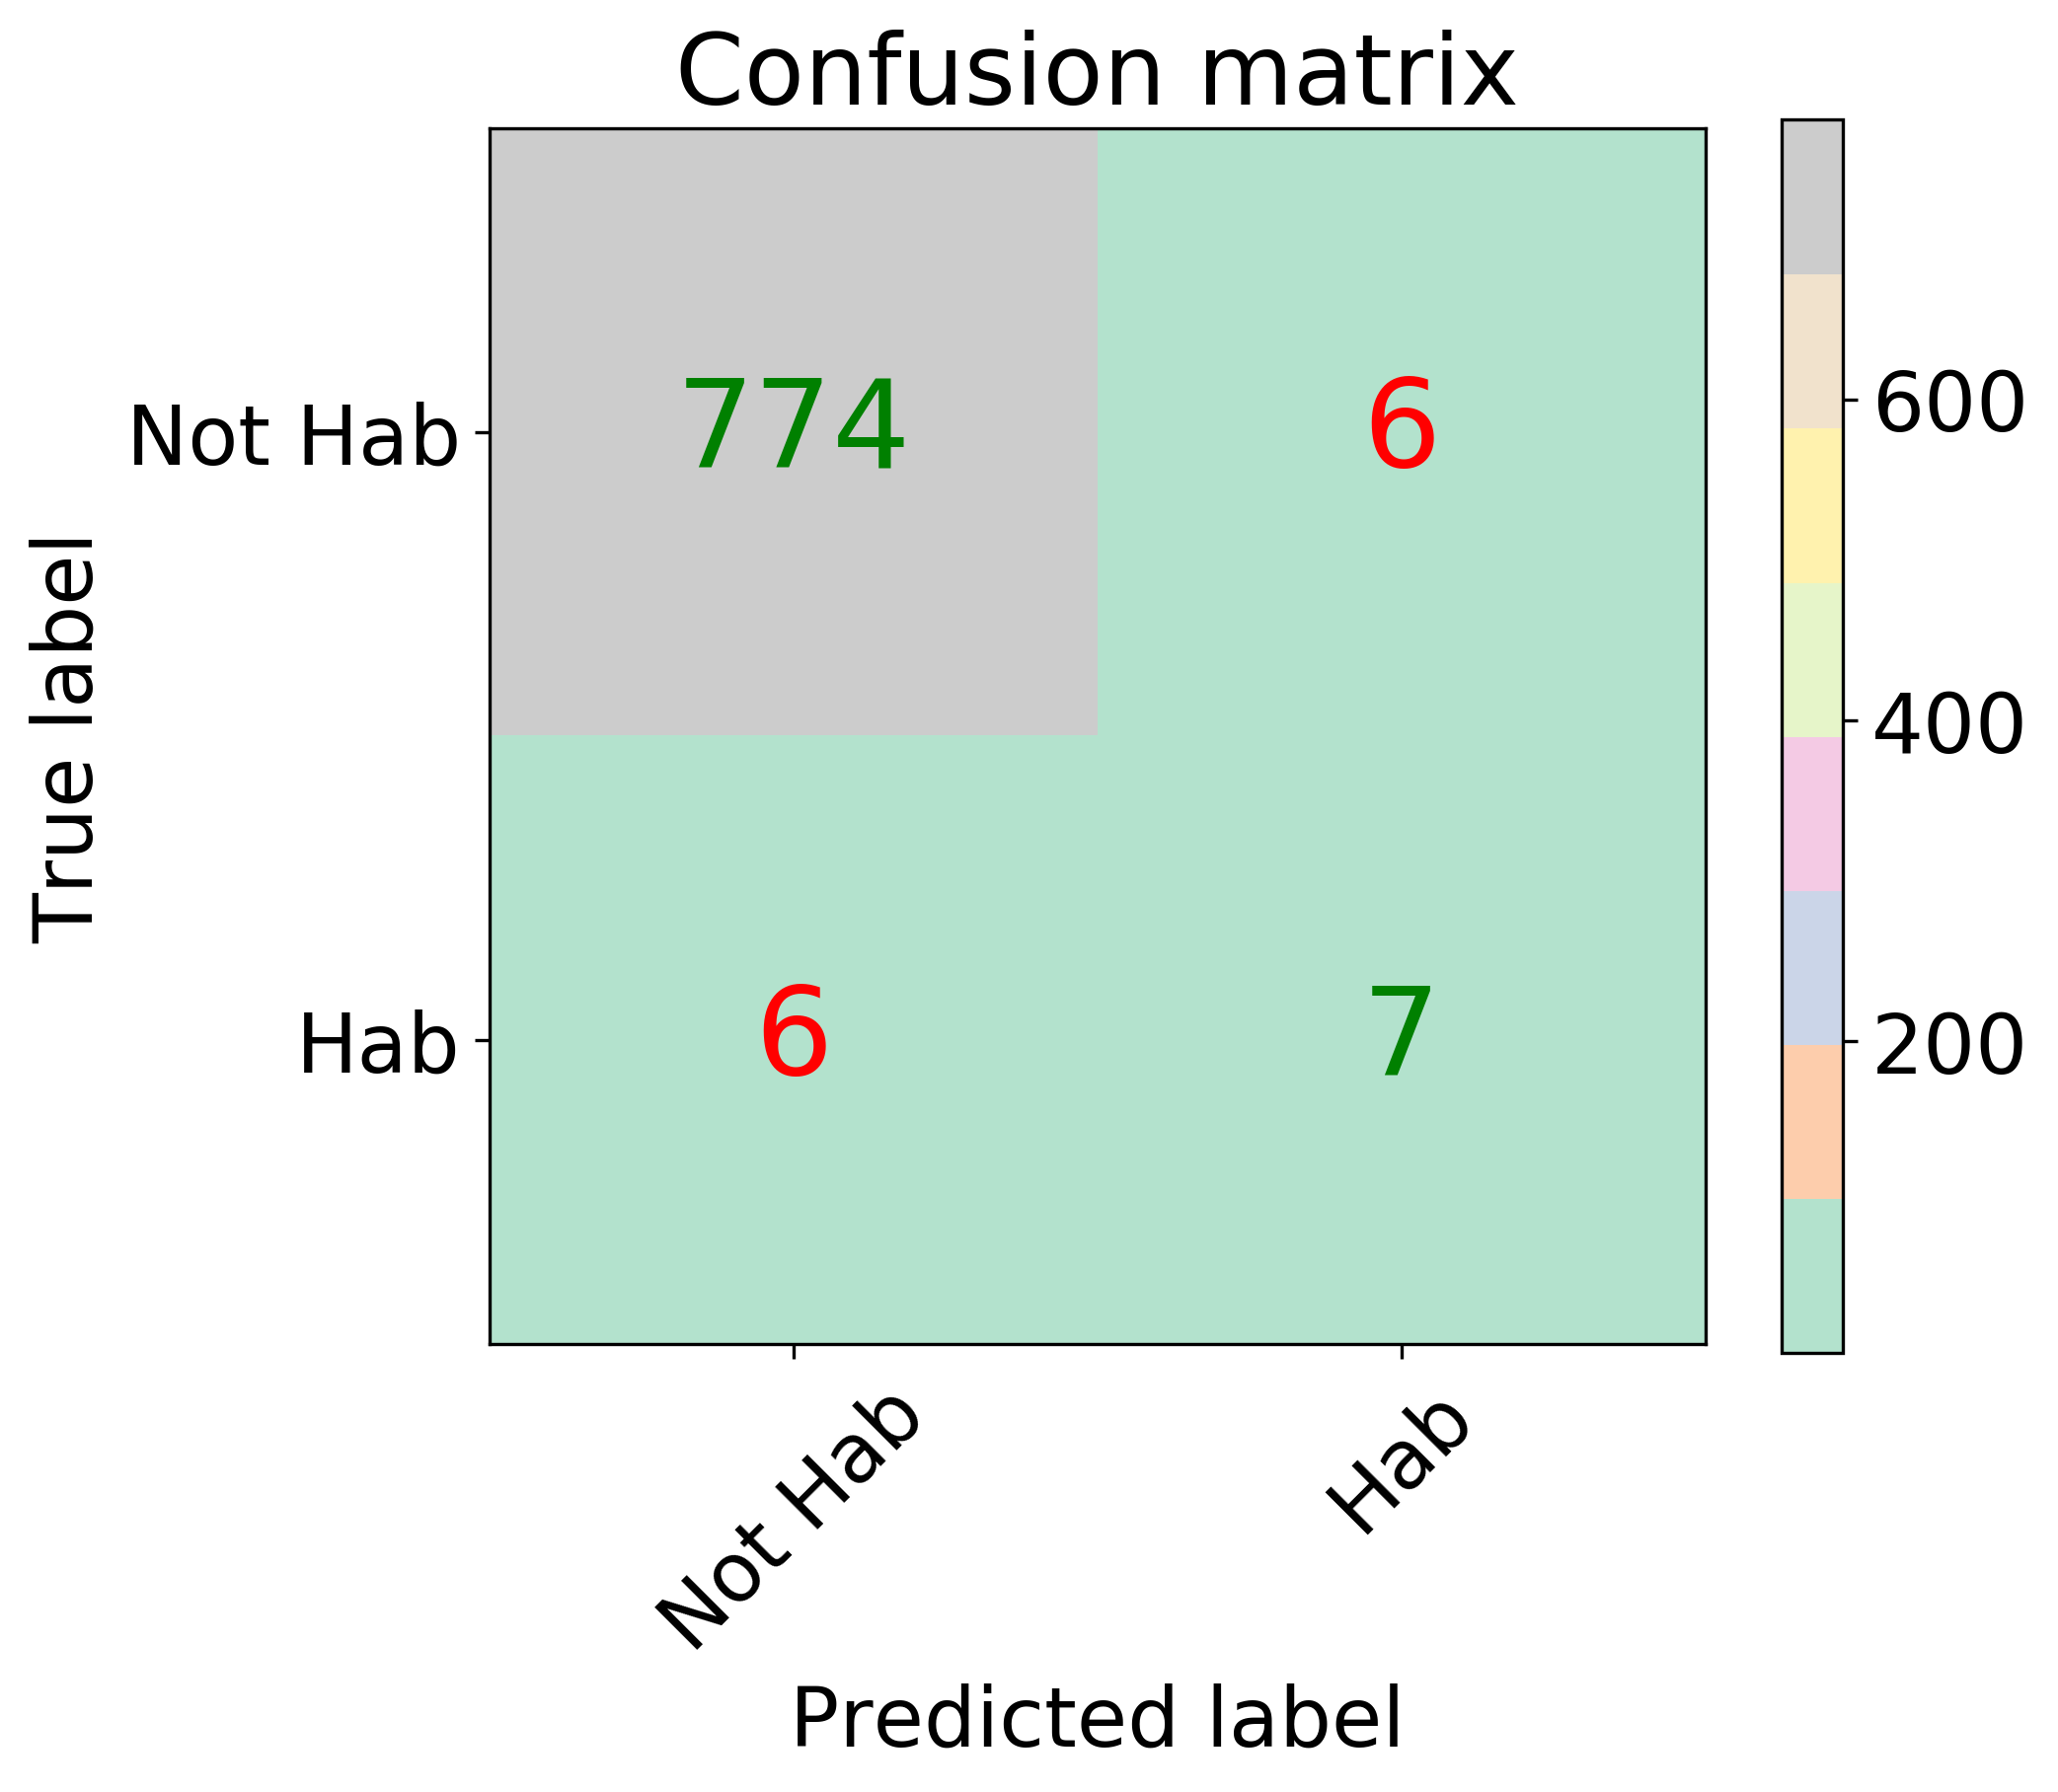

In [42]:
cm = metrics.confusion_matrix(ytest,model.predict(Xtest))

plot_confusion_matrix(cm, ['Not Hab','Hab'], cmap = plt.cm.Pastel2)

### We can now implement three flavors of k-fold Cross Validation.

Note: you can fix the random seed for exactly reproducible behavior.

TL; DR: use the second or the third method.

In [43]:
# This is the standard version. Important: it doesn't shuffle the data, 
# so if your positive examples are all at the beginning or all the end, it might lead to disastrous results.

cv1 = KFold(n_splits = 5)

#This is v2: shuffling added (recommended!)

cv2 = KFold(shuffle = True, n_splits = 5, random_state=5)

# STRATIFICATION ensures that the class distributions in each split resembles those of the 
# entire data set 

cv3 = StratifiedKFold(shuffle = True, n_splits = 5, random_state=5)


### Effect of stratification: let's look at the class count in each set of splits.

In [44]:
for train, test in cv1.split(final_features, targets): #Just how they are in original data set
...     print('train -  {}   |   test -  {}'.format(
...         np.bincount(targets.loc[train]), np.bincount(targets.loc[test])))

train -  [2493   43]   |   test -  [626   9]
train -  [2491   46]   |   test -  [628   6]
train -  [2488   49]   |   test -  [631   3]
train -  [2506   31]   |   test -  [613  21]
train -  [2498   39]   |   test -  [621  13]


In [45]:
for train, test in cv2.split(final_features, targets): #One random selection
...     print('train -  {}   |   test -  {}'.format(
...         np.bincount(targets.loc[train]), np.bincount(targets.loc[test])))

train -  [2491   45]   |   test -  [628   7]
train -  [2496   41]   |   test -  [623  11]
train -  [2498   39]   |   test -  [621  13]
train -  [2493   44]   |   test -  [626   8]
train -  [2498   39]   |   test -  [621  13]


In [46]:
for train, test in cv3.split(final_features, targets): #One adjusted-for random selection
...     print('train -  {}   |   test -  {}'.format(
...         np.bincount(targets.loc[train]), np.bincount(targets.loc[test])))

train -  [2495   41]   |   test -  [624  11]
train -  [2495   42]   |   test -  [624  10]
train -  [2495   42]   |   test -  [624  10]
train -  [2495   42]   |   test -  [624  10]
train -  [2496   41]   |   test -  [623  11]


#### The handy function cross\_validate provides the scores (specified by the chosen scoring parameter), in dictionary form.

In [47]:
scores1 = cross_validate(DecisionTreeClassifier(), final_features, targets, cv = cv1, scoring = 'accuracy')

scores2 = cross_validate(DecisionTreeClassifier(), final_features, targets, cv = cv2, scoring = 'accuracy')

scores3 = cross_validate(DecisionTreeClassifier(), final_features, targets, cv = cv3, scoring = 'accuracy')

In [48]:
scores1

{'fit_time': array([0.01475906, 0.005198  , 0.00637102, 0.00559521, 0.00395489]),
 'score_time': array([0.001544  , 0.00140595, 0.00160408, 0.00174785, 0.00121117]),
 'test_score': array([0.97795276, 0.98264984, 0.9873817 , 0.96687697, 0.98580442])}

#### We can now calculate an average and standard deviation.

In [49]:
print("{:.3f}".format(scores1['test_score'].mean()), "{:.3f}".format(scores1['test_score'].std()))

0.980 0.007


In [50]:
print("{:.3f}".format(scores2['test_score'].mean()), "{:.3f}".format(scores2['test_score'].std()))

0.982 0.008


In [51]:
print("{:.3f}".format(scores3['test_score'].mean()), "{:.3f}".format(scores3['test_score'].std()))

0.983 0.003


#### Question: are the differences statistically significant?

No, because the difference is less than one standard deviation!

### Let's now use recall as our scoring parameter. Will the model change?

In [52]:
scores1 = cross_validate(DecisionTreeClassifier(random_state=1), final_features, targets, cv = cv1, scoring = 'recall')

scores2 = cross_validate(DecisionTreeClassifier(random_state=1), final_features, targets, cv = cv2, scoring = 'recall')

scores3 = cross_validate(DecisionTreeClassifier(random_state=1), final_features, targets, cv = cv3, scoring = 'recall')

In [53]:
print("{:.3f}".format(scores1['test_score'].mean()), "{:.3f}".format(scores1['test_score'].std()))
print("{:.3f}".format(scores2['test_score'].mean()), "{:.3f}".format(scores2['test_score'].std()))
print("{:.3f}".format(scores3['test_score'].mean()), "{:.3f}".format(scores3['test_score'].std()))

0.507 0.241
0.443 0.170
0.425 0.141


### If desired, I can ask for the train scores as well. This is very helpful when diagnosing bias vs variance.

In [54]:
scores1 = cross_validate(DecisionTreeClassifier(), final_features, targets, cv = cv1, scoring = 'recall', \
                         return_train_score = True)

scores2 = cross_validate(DecisionTreeClassifier(), final_features, targets, cv = cv2, scoring = 'recall', \
                         return_train_score = True)

scores3 = cross_validate(DecisionTreeClassifier(), final_features, targets, cv = cv3, scoring = 'recall', 
                         return_train_score = True)

In [55]:
print("{:.3f}".format(scores1['test_score'].mean()), "{:.3f}".format(scores1['train_score'].mean()))
print("{:.3f}".format(scores2['test_score'].mean()), "{:.3f}".format(scores2['train_score'].mean()))
print("{:.3f}".format(scores3['test_score'].mean()), "{:.3f}".format(scores3['train_score'].mean()))

0.400 1.000
0.456 1.000
0.425 1.000


### The cross\_validate function is useful to calculate the score, but does not produce predicted labels.

#### These can be obtained by using the cross\_val\_predict function, which saves the predictions for each of the k test folds, and compiles them together.

In [56]:
model1 = DecisionTreeClassifier(random_state = 3)

y1 = cross_val_predict(model1, final_features, targets, cv = cv1) #these are the predictions,
                                                                #and they are independent of the scoring parameter!

This output is useful to build the "full" confusion matrix:

In [62]:
metrics.confusion_matrix(targets,y1)

array([[3083,   36],
       [  34,   18]])

### However, things may change if I use a different cross validation scheme:

In [63]:
model1 = DecisionTreeClassifier(random_state = 3)

y1 = cross_val_predict(model1, final_features, targets, cv = cv1)

In [64]:
model2 = DecisionTreeClassifier(random_state = 3)

y2 = cross_val_predict(model2, final_features, targets, cv = cv2)

In [65]:
np.sum(y1-y2)

2

In [ ]:
np.sum(y1)

In [66]:
metrics.confusion_matrix(targets,y1)

array([[3083,   36],
       [  34,   18]])

In [67]:
metrics.confusion_matrix(targets,y2)

array([[3091,   28],
       [  28,   24]])

This is a good reminder that the CM is also only one possible realization of the model, and is subject to random fluctuations just like the cross validation scores.

### Finally, we can learn how to plot learning curves, using this handy function from sklearn.

Learning curves are helpful in order to visualize the training scores vs the test scores, and how they vary as a function of data set size. They allow us to determine whether we have enough learning data, AND whether we have a high bias or high variance problem.

The source code below is a slight modification of [this code](https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html).

In [68]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=5,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5), scoring = 'accuracy'):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure(figsize=(10,6))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel(str(scoring))
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring = scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Test score from cross-validation")

    plt.legend(loc="best")
    return plt

In [69]:
model = DecisionTreeClassifier(random_state = 5)

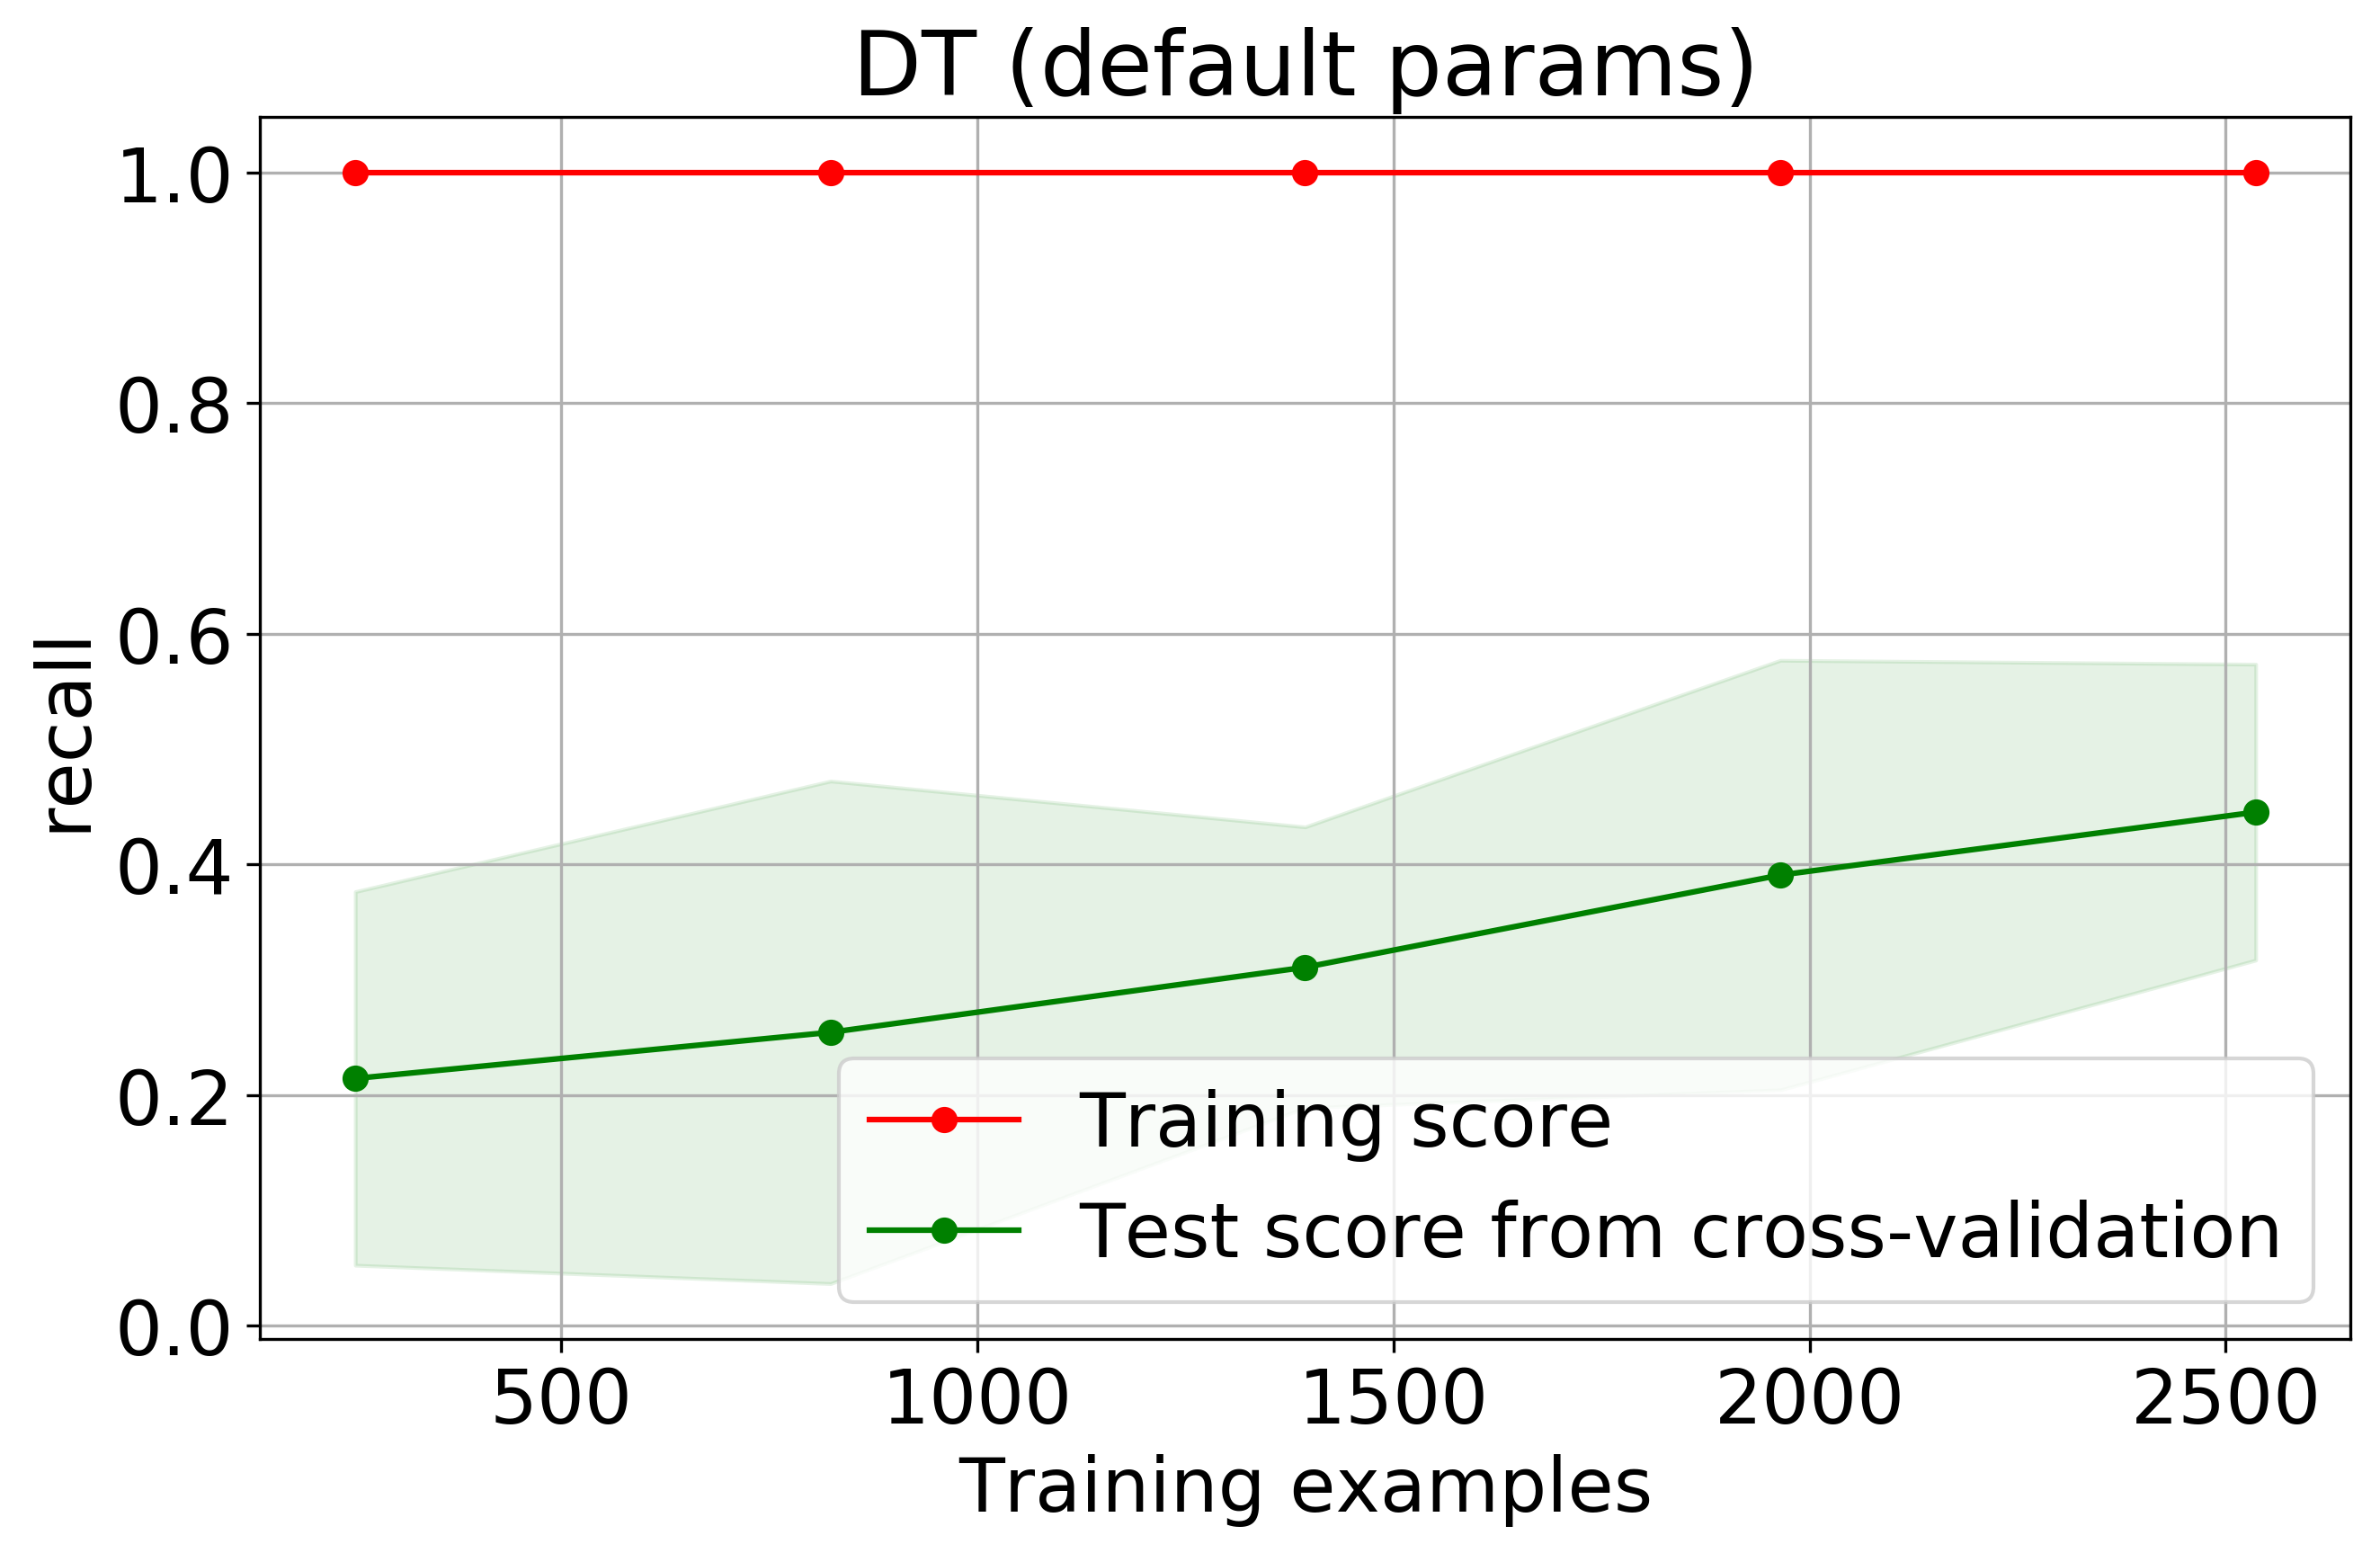

In [70]:
plot_learning_curve(model, 'DT (default params)', final_features, targets,  cv = cv3, scoring = 'recall');

### Conclusions: How is our DT model doing? Does it suffer from high variance or high bias?

The model suffers from severe high variance, as shown by the statistically significant gap between train and test scores. More data will help, as the slope of the test scores seems to be going up.

#### We won't look @ kNN classifier, but you are (of course!) free to play with it.

The draft of Chapter 3 of the book discusses additional applications, like the kNN algorithm results, and the case of a 3-class classifier.